In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from parametres import Paras
from utilities import *
from initialisation import *
from odes import odes_scale_size
import matplotlib.pyplot as plt
from size_scaled_func import *

Initialisation of parametres

In [16]:
N = 20
M = 30
assemblenum = 1 # number of assembly

### initialised parametres
para = Paras(N, M)
p, number = int_preferences(N, M, para.mu_c, assemblenum)
D = int_conversion(M, para.Dbase, assemblenum)
l = int_l(M, para.l_base, assemblenum)
rho = int_rho(M, para.rho_base, assemblenum)
vmax = int_vmax(N, M, para.v_max_base, p, number, assemblenum)
m = int_mt(N, para.m_base, assemblenum)

## Initialised Initial conditions
R0 = int_R(M, para.R0, assemblenum)
C0 = int_C(N, para.w, assemblenum)

# Load parametres
para.paras(C0, R0, l, rho, p, vmax, m, D)
time = np.linspace(0, 5000, 100000)

In [17]:
pars = (para.l, para.m, para.rho, para.mu, para.km, para.p, para.D, para.v_in_max, para.type, para.B0, para.M0, para.E0, para.alpha, para.gamma, para.R_half)
y0 = np.concatenate((R0, C0)).reshape(M+N,) # initial conditions

In [18]:
result = solve_ivp(
    odes_scale_size, t_span=[time[0], time[-1]], y0=y0, t_eval=time, args=pars, dense_output=True)

In [19]:
Rt = result['y'][0:M]
Ct = result['y'][M:M+N]
t = result['t']

In [20]:
t.shape

(100000,)

In [21]:
Rt.shape

(30, 100000)

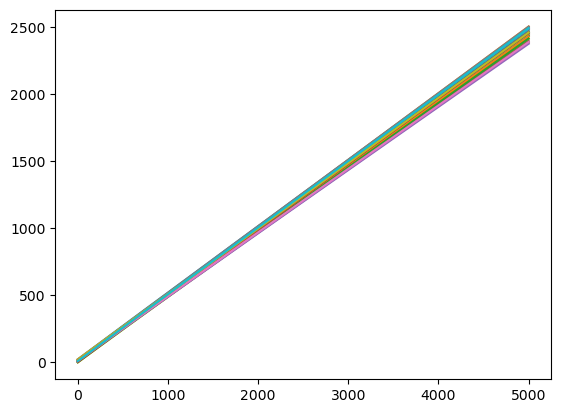

In [22]:
for i in range(M):
    plt.plot(t, Rt[i, :])

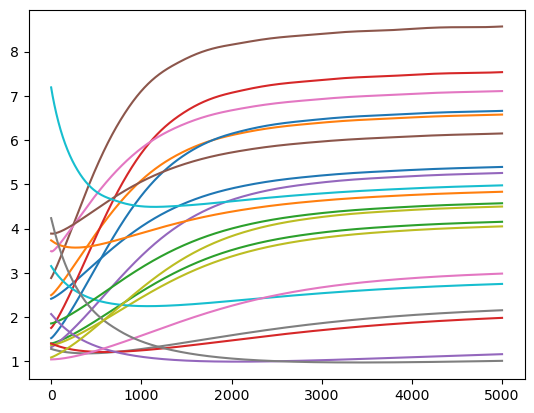

In [23]:
for i in range(N):
    plt.plot(t, Ct[i, :])

In [24]:
Rt.shape

(30, 100000)

In [25]:
species1vg = []

In [26]:
Ct[:, i]

array([2.41691517, 2.49929302, 1.40757075, 1.75876308, 1.32206672,
       2.88904673, 3.48932617, 1.283355  , 1.36742121, 3.15122331,
       1.52776724, 3.7345507 , 1.85920124, 1.40566223, 2.06920062,
       3.88883315, 1.04604106, 4.22963347, 1.09122377, 7.17974282])

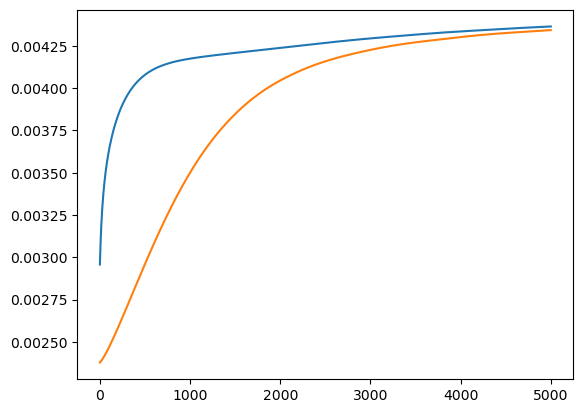

In [27]:
species1vg = []
m1 = []
for i in range(len(t)):
    resourcet = Rt[:, i].reshape(M, 1)
    masst = Ct[:, i].reshape(N, 1)
    v_in = vin(para.p, resourcet, para.R_half, vmax=para.v_in_max, type=2)
    v_in = scale_vin(v_in, masst, para.B0, para.alpha)
    v_g = vgrow(v_in, para.l)[0]
    species1vg.append(v_g)
    m_scale = scale_mt(para.m, masst, para.M0, para.alpha)[0]
    m1.append(m_scale)


plt.plot(t, species1vg)
plt.plot(t, m1)

In [28]:
max(species1vg)

array([0.00436507])

In [29]:
np.max(para.v_in_max)

3.4745359870677293